# Text Emotion Classification

The goal of this project is to build an AI model that can accurately classify text based on emotion.
I'm using a [dataset](https://www.kaggle.com/datasets/parulpandey/emotion-dataset/data) of over 10,000 labeled personal tweets to train my model.

Some key insights I want to explore include:
* What are the common words used across different sentiments?
* The differences between using a probabilistic model like Naive Bayes vs. using an RNN.

## Accessing the Data

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
emotions_df = pd.read_csv('./dataset/training.csv')
emotions_df.head()
emotions_df.columns

Index(['text', 'label'], dtype='object')

In [52]:
# a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4).

emotions_with_labels = emotions_df.copy()
emotions_with_labels['label'] = emotions_with_labels['label'].replace({0:'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5:'surprise'})


<Axes: xlabel='label'>

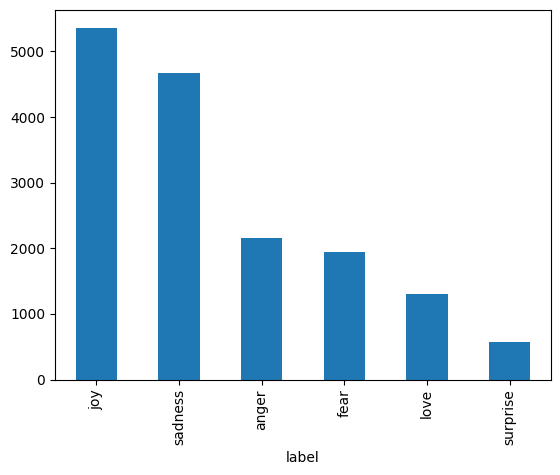

In [53]:
# this tells me that the dataset is kinda balanced and it'll be good for distinguishing joy and sadness

emotions_with_labels.value_counts('label')
emotions_with_labels['label'].value_counts().plot(kind='bar')

In [54]:
emotions_with_labels[emotions_with_labels['label'] == 'love'].head()
emotions_with_labels.isna().sum()
# emotions_with_labels.iloc[14].text

text     0
label    0
dtype: int64

## Preprocessing

In [55]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [56]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)         # remove punctuation
    text = re.sub(r'\d+', '', text)             # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()    # remove extra spaces
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')]) # remove stopwords
    return text

In [57]:
emotions_with_labels['text'] = emotions_with_labels['text'].apply(preprocess)
emotions_with_labels['text'] = emotions_with_labels['text'].apply(word_tokenize)

In [58]:
emotions_with_labels['text'].head()

0                            [didnt, feel, humiliated]
1    [go, feeling, hopeless, damned, hopeful, aroun...
2    [im, grabbing, minute, post, feel, greedy, wrong]
3    [ever, feeling, nostalgic, fireplace, know, st...
4                                   [feeling, grouchy]
Name: text, dtype: object

## Wordcloud

In [59]:
from wordcloud import WordCloud

def plot_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords.words('english'), 
                min_font_size = 10).generate(text) 
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

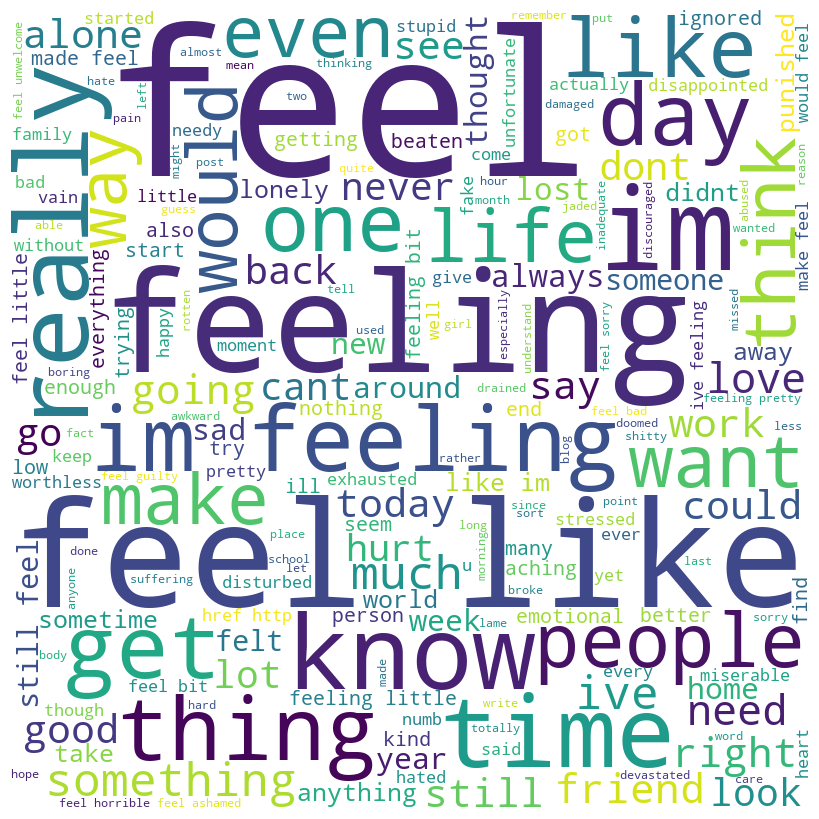

In [60]:
# emotions_with_labels[emotions_with_labels['label'] == 'joy']['text']
word_cloud = emotions_with_labels[emotions_with_labels['label'] == 'sadness']['text']
word_cloud = word_cloud.dropna().apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))  # Convert lists to strings
plot_wordcloud(" ".join(word_cloud))

## Making the Model - Multinomial Naive Bayes

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# splitting data
X = emotions_with_labels['text'].astype(str)  # Ensure text is string type
y = emotions_with_labels['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=7500)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# encode labels if needed
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# train model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [62]:
y_pred = nb.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6872


## Evaluating Model

              precision    recall  f1-score   support

       anger       0.91      0.38      0.54       427
        fear       0.91      0.30      0.46       397
         joy       0.62      0.98      0.76      1021
        love       1.00      0.06      0.11       296
     sadness       0.71      0.94      0.81       946
    surprise       1.00      0.01      0.02       113

    accuracy                           0.69      3200
   macro avg       0.86      0.45      0.45      3200
weighted avg       0.77      0.69      0.62      3200



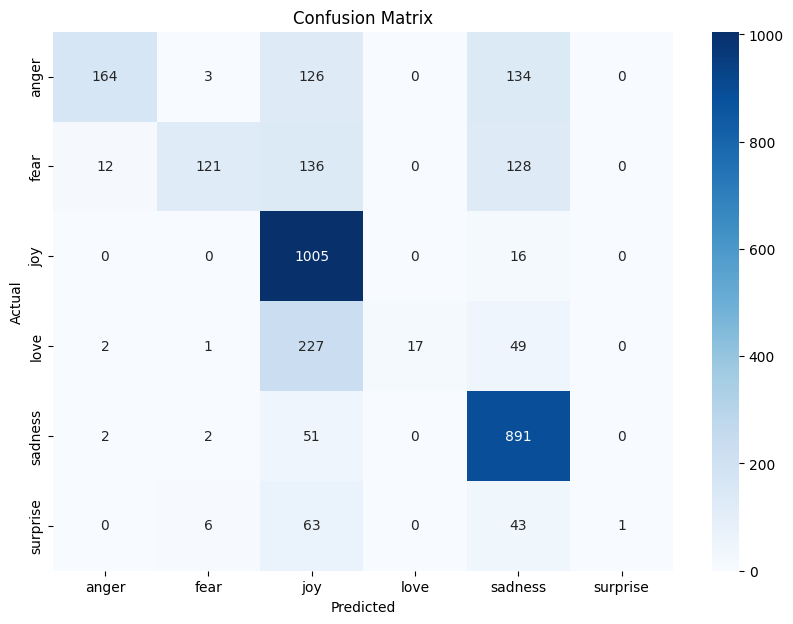

In [63]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [64]:
# testing the model for fun lol
def predict_emotion(text):
    text = preprocess(text)
    text = " ".join(word_tokenize(text))
    sample_text_tfidf = tfidf.transform([text])

    probs = nb.predict_proba(sample_text_tfidf)[0]  # returns an array of probabilities
    pred = nb.predict(sample_text_tfidf)[0]
    predicted_label = le.inverse_transform([pred])[0]
    class_probs = dict(zip(le.classes_, probs))
    
    return predicted_label, class_probs

In [76]:
sentence = "I am so happy today"
predict_emotion(sentence)

('joy',
 {'anger': np.float64(0.06727087205540033),
  'fear': np.float64(0.03091843468174305),
  'joy': np.float64(0.6342407576372788),
  'love': np.float64(0.018301312092982597),
  'sadness': np.float64(0.24503254105659397),
  'surprise': np.float64(0.004236082476001984)})

## Insights

By using Multinomial Naive Bayes, we observe that the model performs well in identifying 'Joy' and 'Sadness' but struggles to distinguish other emotions.

This is partly due to the influence of prior probabilities in Naive Bayes.

Since our training data is predominantly labeled as 'Joy' and 'Sadness', their prior probabilities are around 40%.

As a result, the model is biased toward these emotions, making it more likely to classify text as 'Joy' or 'Sadness' rather than less frequent emotions like 'Fear' or 'Anger'.

It's also important to note that the order of words does not matter in Naive Bayes, as it assumes all events are independent (conditional independence).

## Making the Model - Recurrent Neural Network

In [66]:
emotions_df = pd.read_csv('./dataset/training.csv')
emotions_with_labels = emotions_df.copy()
emotions_with_labels['label'] = emotions_with_labels['label'].replace({0:'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5:'surprise'})
emotions_with_labels['text'] = emotions_with_labels['text'].apply(preprocess)
emotions_with_labels['text'] = emotions_with_labels['text'].apply(word_tokenize)

In [67]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [68]:
""" if you want to know whats going on ...

we are preprocessing our data to feed it into our neural network

Tokenizer
- think of it as if we're creating a dictionary of words from our text
- ** however, we're only going to use the 5000 most common words in our text **
- tokenizer will assign a unique number to each word in the dictionary
- fit_on_texts() will create the dictionary based on the text from our DataFrame

texts_to_sequences
- this function will convert our text to a sequence of numbers
- each number will represent a word from our dictionary
- example: If our dictionary is {'the': 1, 'cat': 2, 'sat': 3}, the sentence "the cat sat" will be converted to [1, 2, 3]


pad_sequences
- this function will make all our sequences the same length
- if a sequence is shorter than the maximum length, we will pad it with zeros
- we want each sequence to have the same length so we can feed them into our neural network


to_categorical
- this function will one-hot encode our labels
- example: [1, 2, 3, 4, 5] will be converted to a matrix where each row represents the number 1-5

"""

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>") 
tokenizer.fit_on_texts(emotions_with_labels['text'])
X = tokenizer.texts_to_sequences(emotions_with_labels['text'])
X = pad_sequences(X, padding='post', maxlen=100)  

y = emotions_with_labels['label'].map({
    'sadness': 0, 
    'joy': 1, 
    'love': 2, 
    'anger': 3, 
    'fear': 4, 
    'surprise': 5
})

y = to_categorical(y, num_classes=6) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
""" if you want to know whats going on ...

we are creating a specific kind of RNN known as an LSTM
the idea of an RNN is still there, but think of an LSTM as a more advanced version of an RNN

Embedding Layer - this layer will convert our sequences of numbers into word vectors
- word vectors are multi-dimensional representations of words
- these vectors will be learned during training

LSTM Layer - this layer will learn the patterns in our sequences
- it will remember important information and forget irrelevant information
- this layer will output a sequence of vectors

Dense Layer - this layer will take the output from the LSTM layer and learn to make predictions
- it will output a vector of probabilities for each class
- the class with the highest probability will be the predicted class

Dropout Layer - this layer will prevent overfitting
- it will randomly set a fraction of input units to 0 at each update during training
- this will help prevent the model from memorizing the training data

"""

# LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=100))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

# output layer
model.add(Dense(6, activation='softmax'))  # 6 output classes for the emotions

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])


c:\Users\ryana\Desktop\CSUF\ACM - AI BOARD\venv3.11\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [70]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping])


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 149ms/step - accuracy: 0.3313 - loss: 1.6067 - val_accuracy: 0.5853 - val_loss: 1.1055
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 161ms/step - accuracy: 0.6871 - loss: 0.8630 - val_accuracy: 0.8247 - val_loss: 0.5205
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 155ms/step - accuracy: 0.8779 - loss: 0.3662 - val_accuracy: 0.8784 - val_loss: 0.3495
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 152ms/step - accuracy: 0.9394 - loss: 0.1919 - val_accuracy: 0.8850 - val_loss: 0.3414
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 153ms/step - accuracy: 0.9555 - loss: 0.1392 - val_accuracy: 0.8913 - val_loss: 0.3440
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 162ms/step - accuracy: 0.9617 - loss: 0.1211 - val_accuracy: 0.8906 - val_loss: 0.3733
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.9671 - loss: 0.0962 - val_accuracy: 0.8900 - val_loss: 0.3877


In [71]:
# evaluating and saving the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
model.save('emotion_classifier_model.h5')

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8757 - loss: 0.3693


Test Accuracy: 0.8850


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


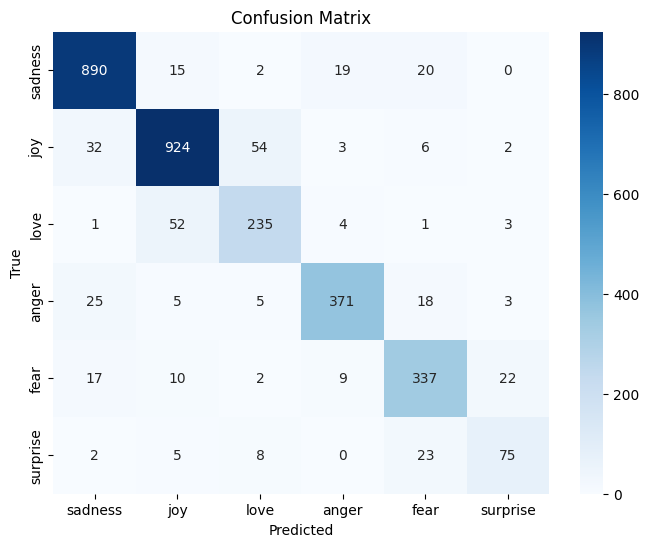

In [72]:
class_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
y_test_labels = np.argmax(y_test, axis=1)

# get predictions on the test set
y_pred = model.predict(X_test)

# convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [73]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_input(text):
    text = preprocess(text)         # this is the same preprocess function we defined earlier
    tokens = word_tokenize(text) 
    return tokens


def predict_sentiment_with_probabilities(sentence):

    """ 
    
    1. preprocess the sentence 
    2. convert sentence into tokens
    3. convert tokens into sequence
    4. pad the sequence for model
    5. make the prediction
    6. get the probabilities for each emotion 
    
    """

    tokens = preprocess_input(sentence)
    
    sequence = tokenizer.texts_to_sequences([tokens])  
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=100)  
    prediction = model.predict(padded_sequence) 
    
    # get the probabilities for each emotion
    predicted_probabilities = prediction[0]  # The output of the model is a list of probabilities
    
    # mapping from predicted class index to emotion
    emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    
    # dictionary of emotions with their corresponding probabilities
    emotion_probabilities = {emotions[i]: predicted_probabilities[i] for i in range(len(emotions))}
    
    return emotion_probabilities


In [74]:
sentence = "how could you?"
emotion_probabilities = predict_sentiment_with_probabilities(sentence)

# print probabilities for all emotions
for emotion, probability in emotion_probabilities.items():
    print(f"{emotion}: {probability:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
sadness: 0.1651
joy: 0.0739
love: 0.0087
anger: 0.3870
fear: 0.3220
surprise: 0.0434


## Comparing Both Models

In [87]:
sentence = "i do not like you"       # modify this sentence !    

print(f'SENTENCE: {sentence}\n')

label, probabilities = predict_emotion(sentence)
print("Multinomial Naive Bayes Model")
print("Predicted Label:", label)
for emotion, prob in probabilities.items():
    print(f'{emotion} - {prob:.4f}')

print("\nRNN Model")
emotion_probabilities = predict_sentiment_with_probabilities(sentence)
print("Predicted Label:", max(emotion_probabilities, key=emotion_probabilities.get))
for emotion, probability in emotion_probabilities.items():
    print(f"{emotion} - {probability:.4f}")
    

SENTENCE: i do not like you

Multinomial Naive Bayes Model
Predicted Label: joy
anger - 0.1099
fear - 0.0598
joy - 0.4236
love - 0.0551
sadness - 0.3430
surprise - 0.0086

RNN Model
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Label: anger
sadness - 0.2530
joy - 0.1808
love - 0.0106
anger - 0.2795
fear - 0.2441
surprise - 0.0320


## Insights

There’s a clear trade-off: while the RNN slightly reduces accuracy for "joy" and "sadness," it improves the detection of other emotions according to our test data. This happens because an RNN considers the context of the sentence, processing words sequentially rather than treating them independently.

For example, consider the sentence: "I do not like you."

With Naive Bayes, each word is treated separately, as if adding up sentiment scores (e.g., "happy" contributes positively regardless of "not"). This can lead to misclassifications.

In contrast, an RNN processes the sentence in order, allowing it to understand how words interact. Because of this, it can better capture nuances like negation ("not happy") and detect a wider range of emotions more accurately.